# Stochastics Methods for Reservoir Modeling
## Group 5

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
sns.set_style('white')

### Tabular Data Structures

In [2]:
os.chdir('C:\\Users\\jjs4476\\Documents\\Stochastic Methods for Reservoir Modeling')

In [3]:
df = pd.read_csv('5_sample_data.csv')
df.head(10)

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,1,70.0,860.0,1.0,0.118640,3.117596,7035.590426
1,3,70.0,720.0,1.0,0.120775,1.755401,6327.155846
2,5,70.0,580.0,1.0,0.152136,90.385506,5547.976415
3,6,70.0,510.0,1.0,0.148497,81.199756,4025.534147
4,8,70.0,370.0,1.0,0.158123,1497.094898,4385.428975
5,9,70.0,300.0,1.0,0.132016,6292.156474,4912.077977
6,10,70.0,230.0,1.0,0.145744,3713.824769,5151.593694
7,11,70.0,160.0,1.0,0.168037,537.660203,5440.911268
8,12,70.0,90.0,1.0,0.128605,27.417819,5929.812808
9,15,140.0,860.0,1.0,0.093445,7.373822,6439.805211


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 7 columns):
Unnamed: 0    292 non-null int64
X             292 non-null float64
Y             292 non-null float64
Facies        292 non-null float64
Porosity      292 non-null float64
Perm          292 non-null float64
AI            292 non-null float64
dtypes: float64(6), int64(1)
memory usage: 16.0 KB


In [5]:
df = df.rename(columns={'Unnamed: 0': 'Sample_n'})

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sample_n,292.0,281.900685,171.078850,1.000000,125.000000,277.500000,429.250000,587.000000
X,292.0,449.332192,278.046974,0.000000,210.000000,420.000000,670.000000,990.000000
Y,292.0,525.859589,272.450211,19.000000,300.000000,519.000000,790.000000,999.000000
Facies,292.0,0.760274,0.427649,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,292.0,0.118647,0.028933,0.035663,0.098147,0.115953,0.137315,0.210431
Perm,292.0,1037.004990,3554.702715,0.007069,1.300500,11.447706,201.220948,26466.744985
AI,292.0,6221.134204,1321.141171,3492.039443,5197.953236,6145.967479,7199.155125,9197.475148


In [7]:
np.log(0.007069)

-4.95203625179332

In [8]:
df.shape

(292, 7)

### Regular Gridded Data Structures

In [9]:
# utility to convert 1D or 2D numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name
    
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods (commented out image file creation)
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
#    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

In [10]:
AI_map = pd.read_csv('5_AI.csv', header=None)   # Read the AI 2D grid as a DataFrame. There is no header
AI_map = AI_map.values  # Get only the np values

**Visualization**

**Summary statistics**

In [11]:
xmin = 0.0 
xmax = 1000.0
ymin = 0.0
ymax = 1000.0
cell_size = 10.0
gcsize = 10.0;                          # grid cell size
vmin = np.ceil(AI_map.min())
vmax = np.ceil(AI_map.max())
cmap = plt.cm.plasma

In [12]:
np.ceil(AI_map.max())

10004.0

In [13]:
stats = stats.describe(AI_map.flatten())
stats

DescribeResult(nobs=10000, minmax=(3041.1785908071197, 10003.558948893804), mean=6577.0, variance=1730450.2050205024, skewness=-0.15308727756669102, kurtosis=-0.6100682427084996)

In [14]:
mean_AI = np.mean(AI_map)                                 # array summary statistics
stdev_AI = np.std(AI_map)
min_AI = np.min(AI_map)
max_AI = np.max(AI_map)
P10_AI ,P90_AI = np.percentile(AI_map,[0.10,0.90])
print('Summary Statistics of AI \n Mean = ' + str(mean_AI) + ', StDev = ' + str(stdev_AI))
print(' Min = ' + str(min_AI) + ', Max = ' + str(max_AI))
print(' P10 = ' + str(P10_AI) + ', P90 = ' + str(P90_AI))

Summary Statistics of AI 
 Mean = 6577.0, StDev = 1315.3999999999999
 Min = 3041.1785908071197, Max = 10003.558948893804
 P10 = 3261.3782722038095, P90 = 3722.6077429307097


### GeostatsPy: Basic Univariate Statistics and Distribution Plotting for Subsurface Data Analytics in Python

In [15]:
import geostatspy.GSLIB as GSLIB           # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats     # GSLIB methods convert to Python

In [16]:
print('The minimum is ' + str(round(np.amin(df['Porosity'].values),2)))
print('The maximum is ' + str(round(np.amax(df['Porosity'].values),2)))
print('The range (maximum - minimum) is ' + str(round(np.ptp(df['Porosity'].values),2)))
print('The P10 is ' + str(round(np.percentile(df['Porosity'].values,10),3)))
print('The P50 is ' + str(round(np.percentile(df['Porosity'].values,50),3)))
print('The P90 is ' + str(round(np.percentile(df['Porosity'].values,90),3)))
print('The P13 is ' + str(round(np.percentile(df['Porosity'].values,13),3)))
print('The media (P50) is ' + str(round(np.median(df['Porosity'].values),3)))
print('The mean is ' + str(round(np.mean(df['Porosity'].values),3)))

The minimum is 0.04
The maximum is 0.21
The range (maximum - minimum) is 0.17
The P10 is 0.083
The P50 is 0.116
The P90 is 0.158
The P13 is 0.087
The media (P50) is 0.116
The mean is 0.119


**Plotting distributions**

In [17]:
GSLIB.hist

<function geostatspy.GSLIB.hist(array, xmin, xmax, log, cumul, bins, weights, xlabel, title, fig_name)>

Let's visualize the histogram of porosity.

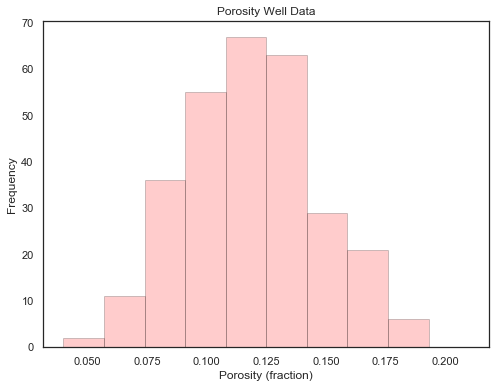

In [18]:
pormin = 0.04
pormax = 0.21
GSLIB.hist(df['Porosity'].values, pormin, pormax, log=False, cumul = False, bins=10,
           weights = None, xlabel='Porosity (fraction)', title='Porosity Well Data', fig_name='hist_Porosity')

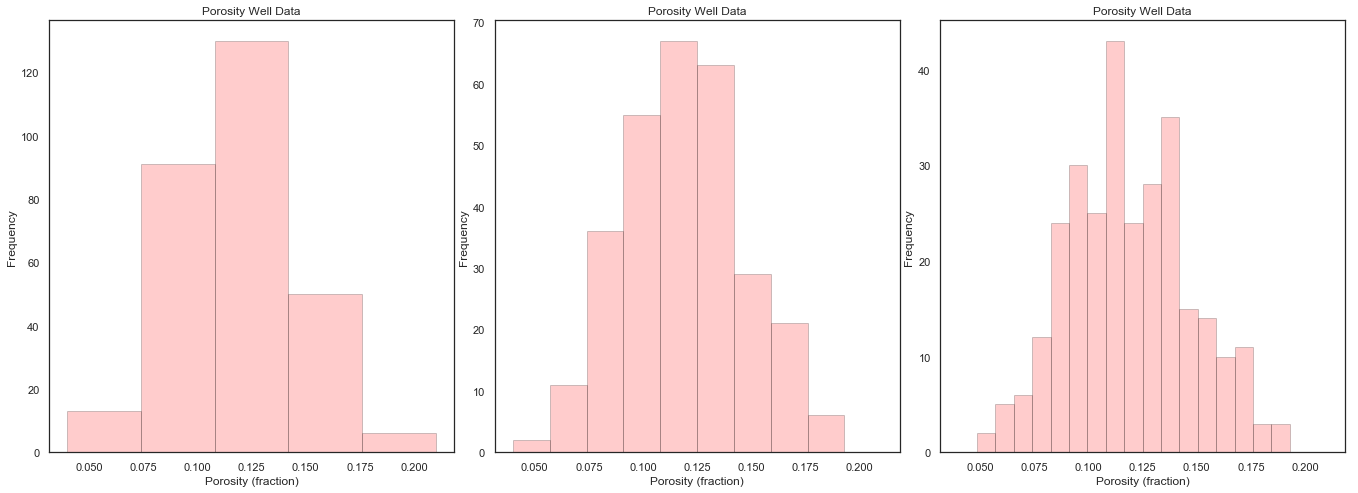

In [19]:
plt.subplot(131)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=5,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(132)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=10,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(133)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.1, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")
plt.show()

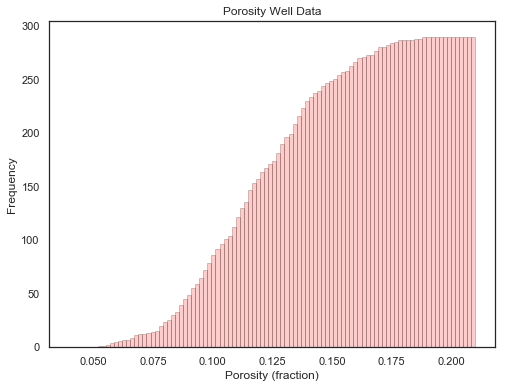

In [20]:
GSLIB.hist(df['Porosity'].values, pormin, pormax, log=False, cumul = True,
           bins=100, weights = None, xlabel='Porosity (fraction)',
           title='Porosity Well Data', fig_name='hist_Porosity_CDF')

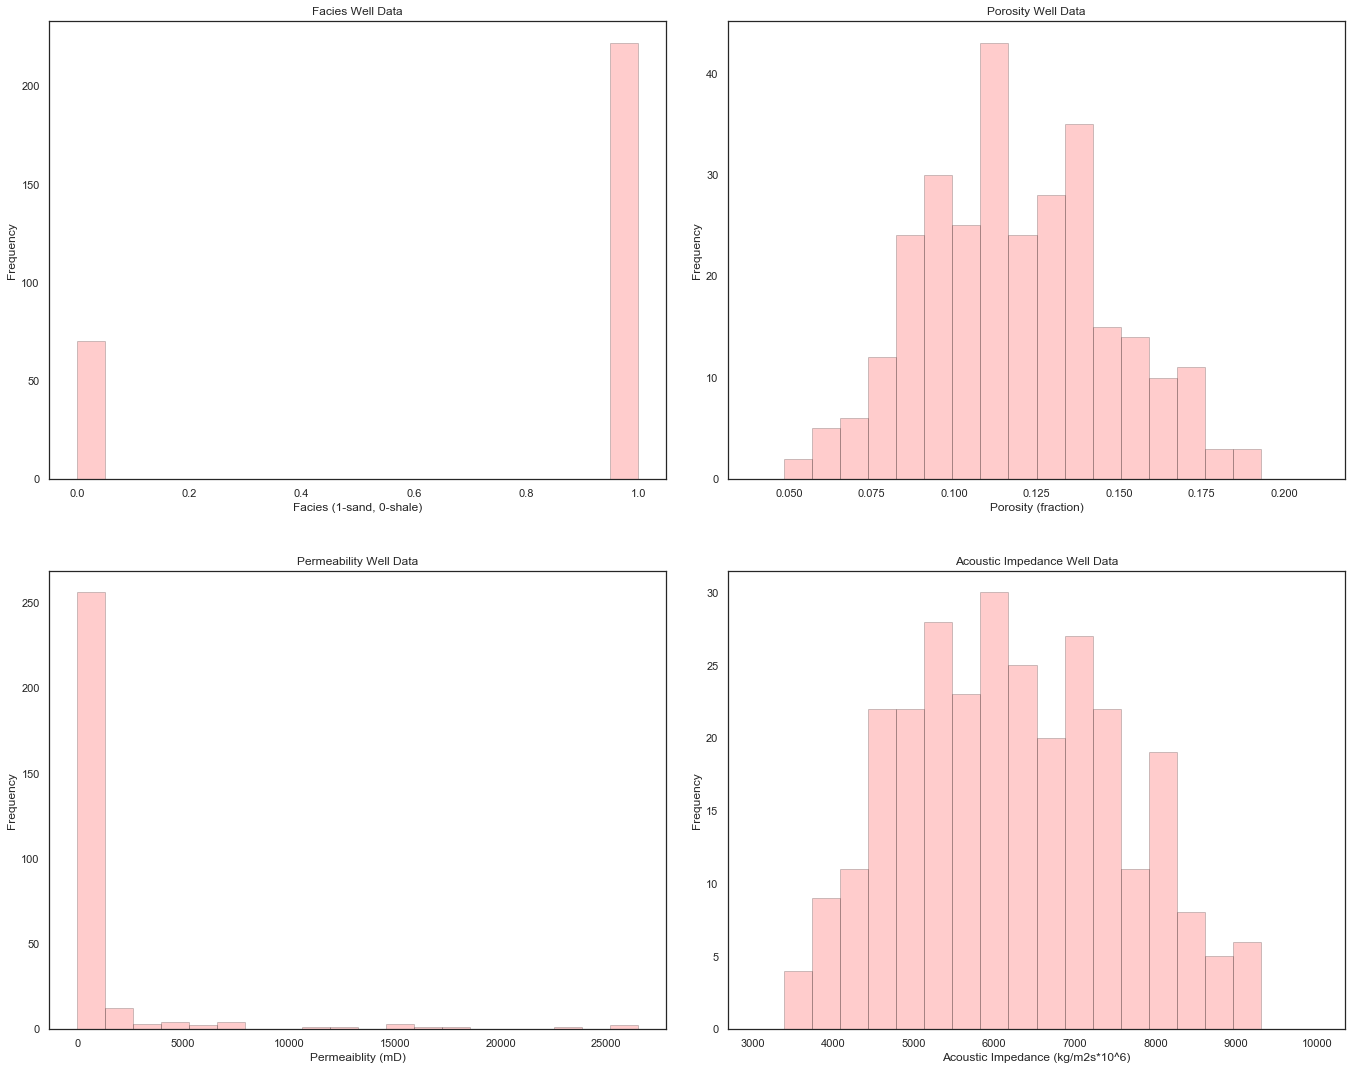

In [21]:
permmin = 0.01
permmax = 26500
AImin = np.ceil(AI_map.min())
AImax = np.ceil(AI_map.max())
Fmin = 0
Fmax = 1

plt.subplot(221)
GSLIB.hist_st(df['Facies'].values,Fmin,Fmax,log=False,cumul = False,bins=20,weights = None,xlabel='Facies (1-sand, 0-shale)',title='Facies Well Data')

plt.subplot(222)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = False,bins=20,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(223)
GSLIB.hist_st(df['Perm'].values,permmin,permmax,log=False,cumul = False,bins=20,weights = None,xlabel='Permeaiblity (mD)',title='Permeability Well Data')

plt.subplot(224)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = False,bins=20,weights = None,xlabel='Acoustic Impedance (kg/m2s*10^6)',title='Acoustic Impedance Well Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")

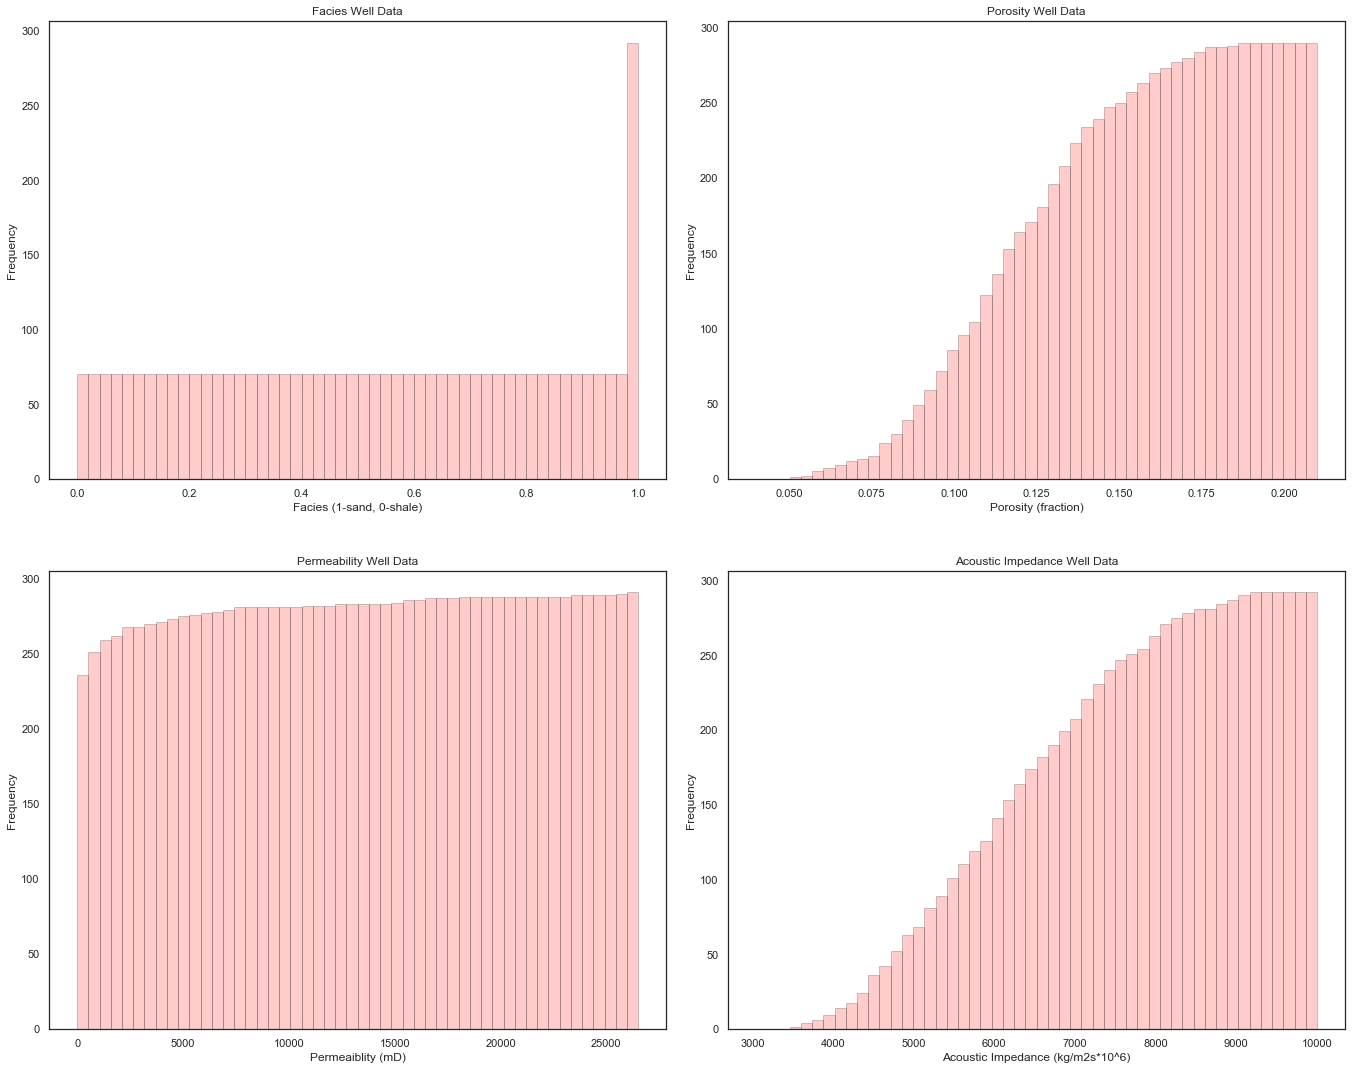

In [22]:
plt.subplot(221)
GSLIB.hist_st(df['Facies'].values,Fmin,Fmax,log=False,cumul = True,bins=50,weights = None,xlabel='Facies (1-sand, 0-shale)',title='Facies Well Data')

plt.subplot(222)
GSLIB.hist_st(df['Porosity'].values,pormin,pormax,log=False,cumul = True,bins=50,weights = None,xlabel='Porosity (fraction)',title='Porosity Well Data')

plt.subplot(223)
GSLIB.hist_st(df['Perm'].values,permmin,permmax,log=False,cumul = True,bins=50,weights = None,xlabel='Permeaiblity (mD)',title='Permeability Well Data')

plt.subplot(224)
GSLIB.hist_st(df['AI'].values,AImin,AImax,log=False,cumul = True,bins=50,weights = None,xlabel='Acoustic Impedance (kg/m2s*10^6)',title='Acoustic Impedance Well Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins.tif',dpi=600,bbox_inches="tight")

### GeostatsPy: Basic Plotting of Subsurface Data

In [23]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

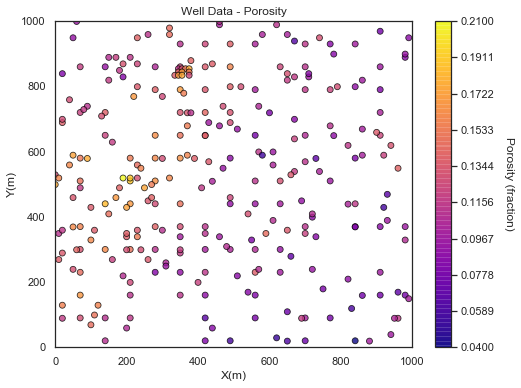

In [24]:
GSLIB.locmap(df, 'X', 'Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
             'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap,'locmap_Porosity');

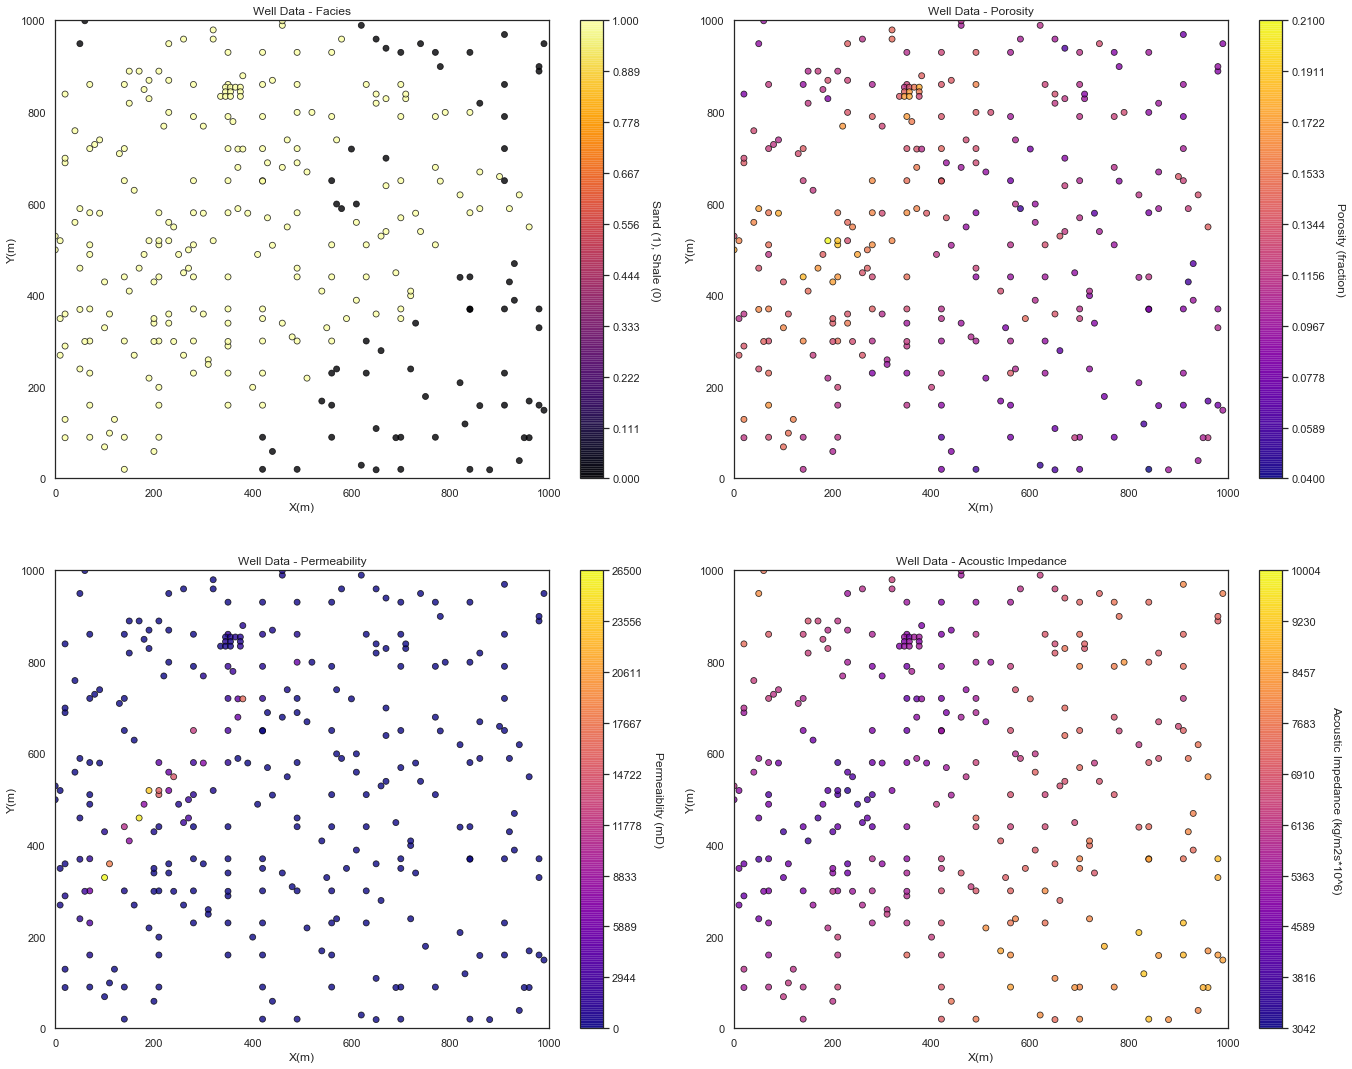

In [25]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y', 'Facies', xmin, xmax, ymin, ymax, Fmin, Fmax,
                'Well Data - Facies', 'X(m)', 'Y(m)', 'Sand (1), Shale (0)', plt.cm.inferno)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y', 'Porosity', xmin, xmax, ymin, ymax, pormin, pormax,
                'Well Data - Porosity', 'X(m)', 'Y(m)', 'Porosity (fraction)', cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y', 'Perm', xmin, xmax, ymin, ymax,permmin, permmax,
                'Well Data - Permeability', 'X(m)', 'Y(m)', 'Permeaiblity (mD)', cmap)

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y', 'AI', xmin, xmax, ymin, ymax, AImin, AImax,
                'Well Data - Acoustic Impedance', 'X(m)', 'Y(m)', 'Acoustic Impedance (kg/m2s*10^6)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2)
plt.savefig('All_location_maps.tif',dpi=600,bbox_inches="tight")

**Seismic data**

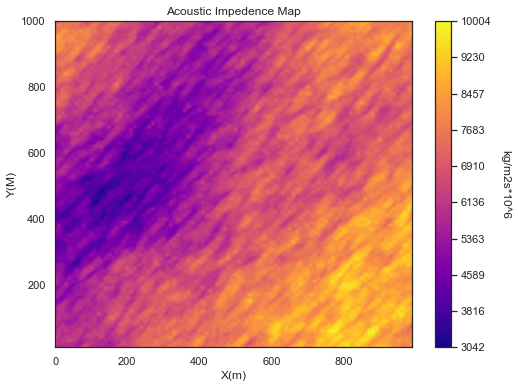

In [26]:
pixelplt(AI_map, xmin, xmax, ymin, ymax, cell_size, vmin, vmax,
         "Acoustic Impedence Map", "X(m)", "Y(M)", 'kg/m2s*10^6' , cmap, "AI_Map");

In [27]:
GSLIB.locpix

<function geostatspy.GSLIB.locpix(array, xmin, xmax, ymin, ymax, step, vmin, vmax, df, xcol, ycol, vcol, title, xlabel, ylabel, vlabel, cmap, fig_name)>

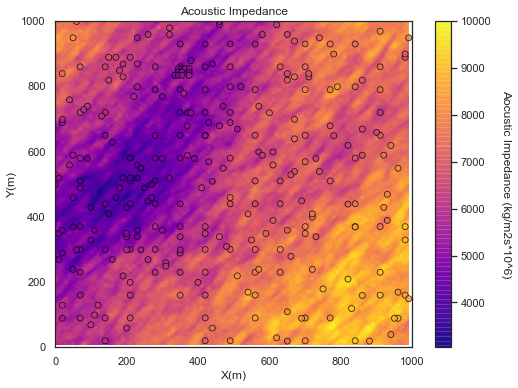

In [28]:
GSLIB.locpix(AI_map, xmin, xmax, ymin, ymax, gcsize, AImin, AImax, df,
             'X', 'Y', 'AI', 'Acoustic Impedance', 'X(m)', 'Y(m)',
             'Aocustic Impedance (kg/m2s*10^6)', cmap, 'pixelplot_Acoustic_Impedance');

In [29]:
df = df.rename(columns={'Facies': 'Facies_2'})
df['Facies'] = np.where(df['Facies_2']==0, 'Shale', 'Sand')
df['log10_Perm'] = np.log10(df['Perm'])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


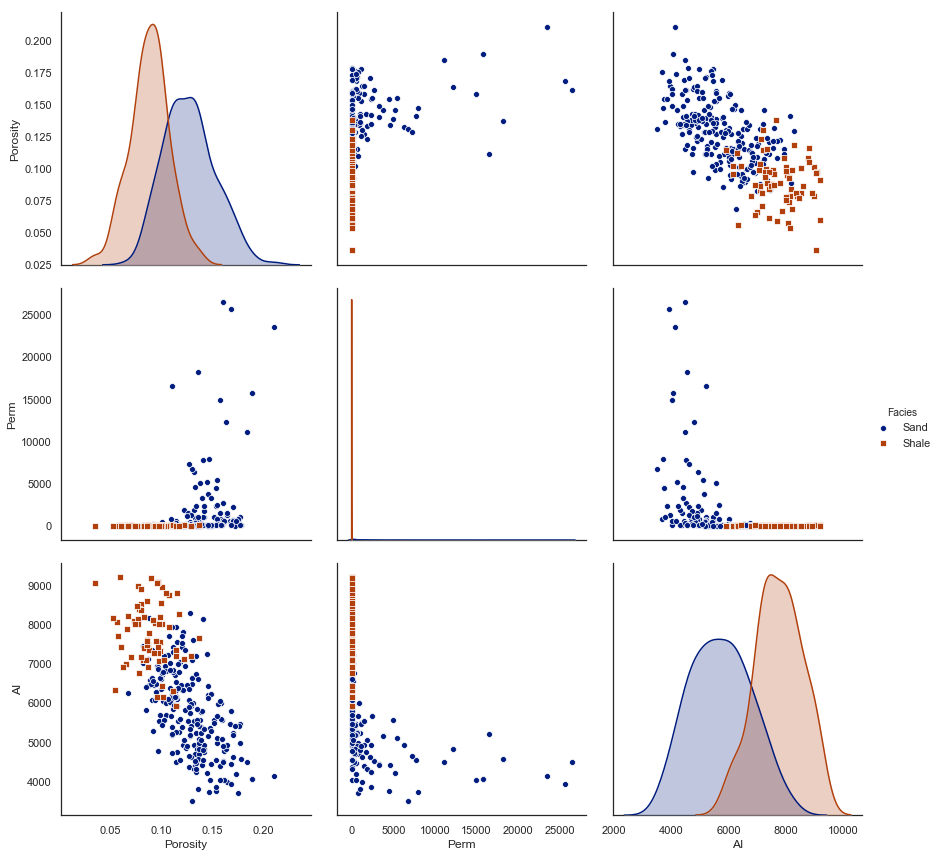

In [30]:
sns.pairplot(df, hue='Facies', height=4, vars=['Porosity', 'Perm', 'AI'], palette='dark', markers=['o', 's']);

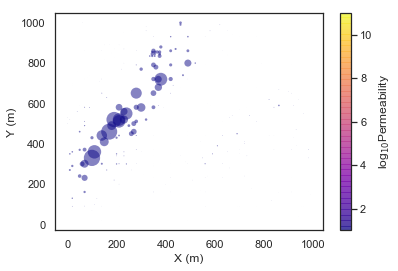

In [31]:
# Extract the data
X, Y = df['X'], df['Y']
porosity, permeability = df['Porosity'], df['Perm']

# Scatter the points, using size and color but no label
plt.scatter(X, Y, label=None, c=porosity, cmap='plasma',
           s=permeability/100, linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.colorbar(label='log$_{10}$Permeability')
plt.clim(1, 11)

In [44]:
variab = df.iloc[:, 4:7]
variab.head()
variab.corr()

,Porosity,Perm,AI
Porosity,1.000000,0.392560,-0.698005
Perm,0.392560,1.000000,-0.391876
AI,-0.698005,-0.391876,1.000000


In [55]:
df_sh = df[df['Facies'] == 'Shale']
df_sd = df[df['Facies'] == 'Sand']

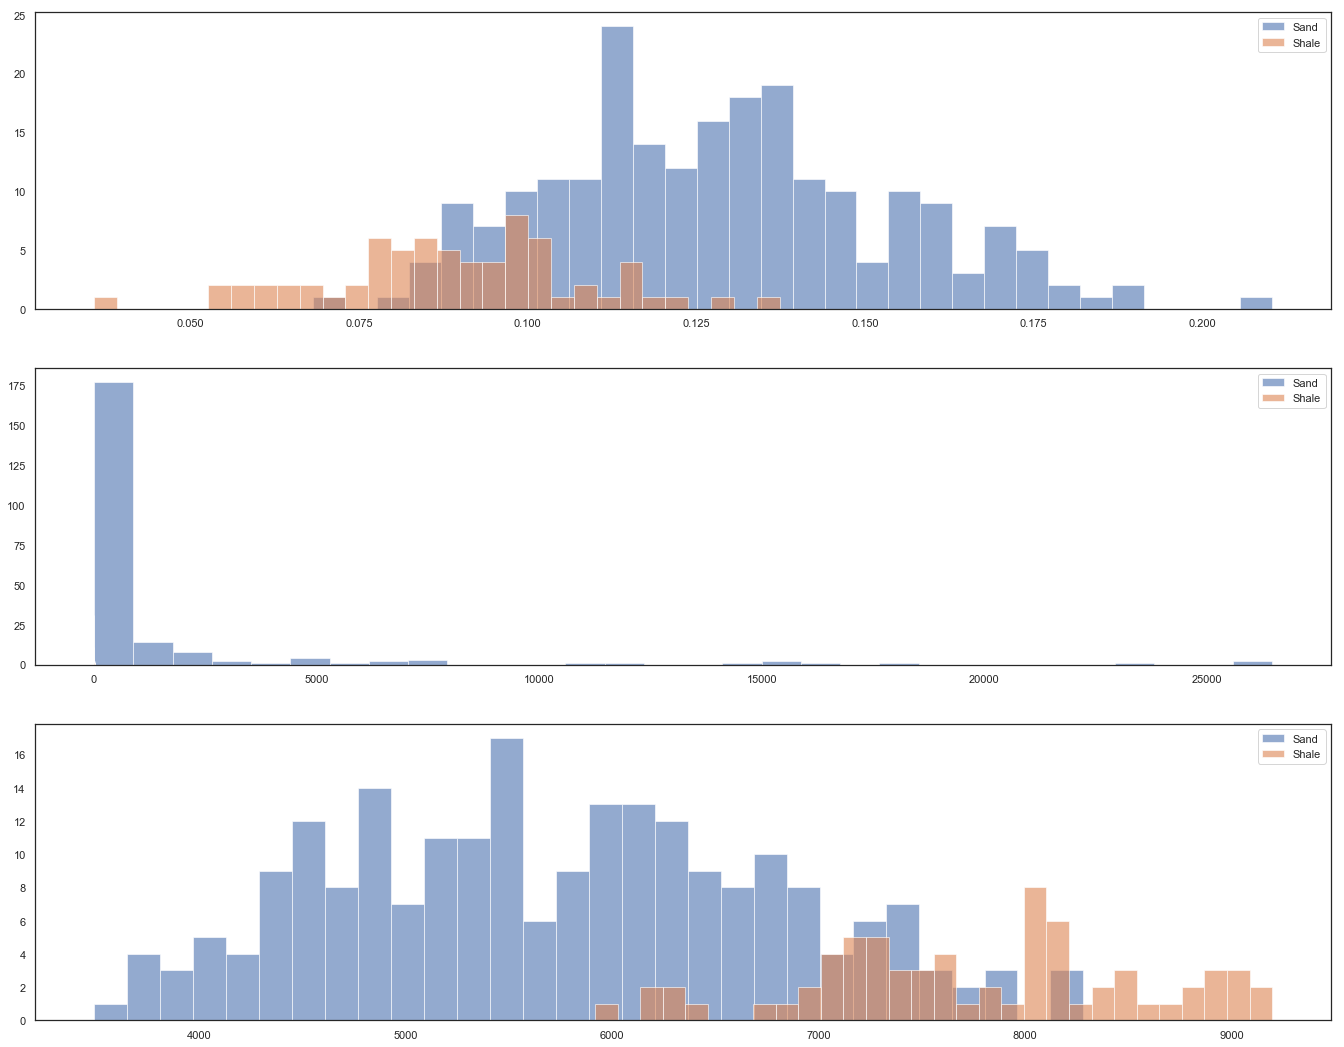

In [95]:
#a4_dims = (4, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
#sns.distplot(df_sd['Porosity'].values, kde=False, rug=False, label='Sand', bins=30)
#sns.distplot(df_sh['Porosity'].values, kde=False, rug=False,  label='Shale', bins=30).
plt.subplot(311)
plt.hist(df_sd['Porosity'].values, label='Sand', bins=30, alpha=0.6)
plt.hist(df_sh['Porosity'].values, label='Shale', bins=30, alpha=0.6)
plt.legend()
ax.set(xlabel='Porosity (fraction)', ylabel='Density', title='Porosity Histogram')

plt.subplot(312)
plt.hist(df_sd['Perm'].values, label='Sand', bins=30, alpha=0.6)
plt.hist(df_sh['Perm'].values, label='Shale', bins=30, alpha=0.6)
plt.legend()
ax.set(xlabel='Permeability (mD)', ylabel='Density', title='Permeability Histogram')

plt.subplot(313)
plt.hist(df_sd['AI'].values, label='Sand', bins=30, alpha=0.6)
plt.hist(df_sh['AI'].values, label='Shale', bins=30, alpha=0.6)
plt.legend()
ax.set(xlabel='AI (units)', ylabel='Density', title='Acoustic Impedance Histogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.1, hspace=0.2);

In [61]:
df_sh['Porosity'].values

array([0.06597858, 0.08274968, 0.05828795, 0.07825956, 0.13735561,
       0.08362052, 0.08047342, 0.0926696 , 0.09886566, 0.11431521,
       0.10056183, 0.07338245, 0.08685488, 0.07802389, 0.09900111,
       0.11506555, 0.10073033, 0.0356633 , 0.09668537, 0.08345143,
       0.10176624, 0.12303637, 0.08753621, 0.09723792, 0.07783778,
       0.09602815, 0.07806782, 0.1080807 , 0.09501644, 0.11577695,
       0.05945138, 0.09424432, 0.09573497, 0.05734864, 0.10757596,
       0.11175496, 0.09232282, 0.11433696, 0.09672862, 0.0665837 ,
       0.0905679 , 0.05531947, 0.06314985, 0.08820067, 0.08585466,
       0.06133407, 0.08042086, 0.10500804, 0.12981684, 0.07029359,
       0.09828462, 0.08613523, 0.08035172, 0.1033183 , 0.0986247 ,
       0.09316976, 0.08052938, 0.08812056, 0.06808875, 0.07773048,
       0.07660255, 0.08633151, 0.11777062, 0.08699027, 0.08640939,
       0.07488066, 0.05305034, 0.10139637, 0.10025807, 0.0977328 ])

https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

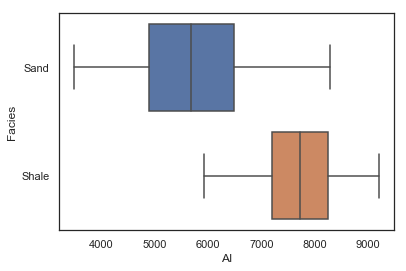

In [34]:
ax = sns.boxplot(x='AI', y='Facies', data=df, whis=np.inf)

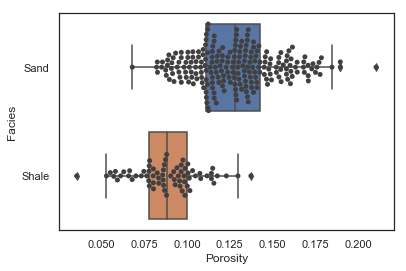

In [35]:
ax = sns.boxplot(x='Porosity', y='Facies', data=df)
ax = sns.swarmplot(x='Porosity', y='Facies', data=df, color='.25') # to show the datapoints on top of the boxes

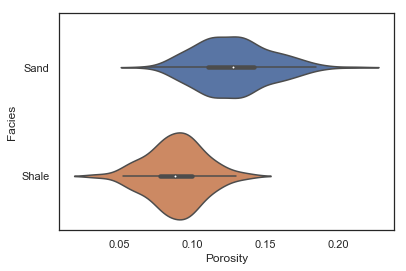

In [36]:
ax = sns.violinplot(x=df['Porosity'], y=df['Facies'])

In [37]:
ax = sns.violinplot(x=df['Permeability'], y=df['Facies'])

KeyError: 'Permeability'

In [ ]:
df.head()